<img src="img/title.png" style="width: 50%;"/>

<img src="img/examples.png" style="width: 100%;"/>

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize as so
from pyDOE import lhs

In [2]:
def simple_model(x):
    f = ((6*x - 2)**2) * np.sin(12*x - 4) 
    return f

In [3]:
class GaussianProcess():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.eps = np.finfo(float).eps

    def get_covar(self, x, theta):
        n, m = x.shape
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                D = (1/theta[0:m]) * (x[i] - x[j]) ** 2
                K[i,j] = np.exp(-sum(D))
                K[j,i] = K[i,j]
        return K + theta[m]*np.eye(n) + np.eye(n)
    
    def train(self):
        n, m = self.x.shape
        bounds = list(zip([0.01]*m, [10]*m))
        bounds.append((self.eps, np.var(self.y)))
        x0 = [0.1] * m 
        x0.append(10e-6 * np.var(self.y))
        result = so.minimize(self._nl, x0=x0, bounds=bounds)
        self.theta = result.x
        
    def _nl(self, theta):
        n, m = self.x.shape
        K = self.get_covar(self.x, theta)
        try:
            L = np.linalg.cholesky(K)
        except np.linalg.linalg.LinAlgError:
            return 10e4
        Ly = np.linalg.solve(L, self.y)
        _, ldetK = np.linalg.slogdet(K)
        ll = -(n/2) * np.log(np.dot(Ly.T, np.linalg.solve(L, self.y))) - (1/2) * ldetK
        return -ll 
        
    def predict(self, xpred):
        n, m = self.x.shape
        if self.theta is None:
            raise 'Need to train before predict'
        K = self.get_covar(self.x, self.theta)
        K_xpred = self.get_covar(xpred, self.theta)

        npred = len(xpred)
        K_aug = np.zeros((npred, n))
        for i in range(npred):
            for j in range(n):
                D = (1/self.theta[0:m]) * (xpred[i] - self.x[j]) ** 2
                K_aug[i,j] = np.exp(-sum(D))
                
        # using chol
        L = np.linalg.cholesky(K)
        Lr = np.linalg.solve(L, K_aug.T)
        mubar = np.dot(Lr.T, np.linalg.solve(L, self.y))
        s2bar = np.clip(K_xpred - np.dot(Lr.T, np.linalg.solve(L, K_aug.T)), 1e-10, np.inf)
        sbar = np.sqrt(np.abs(np.diag(s2bar)))
        return mubar.flatten(), sbar.flatten()
    
    def CDF(self, x):
        return 0.5 * (1 + self.erf(x * np.sqrt(2))) 
            
    def PDF(self, x):
        return np.exp(-0.5 * x**2) / np.sqrt(2*np.pi)
    
    def erf(self, z):
        t = 1.0 / (1.0 + 0.5 * np.abs(z))
        # use Horner's method
        ans = 1 - t * np.exp( -z*z -  1.26551223 +
                                    t * ( 1.00002368 +
                                    t * ( 0.37409196 + 
                                    t * ( 0.09678418 + 
                                    t * (-0.18628806 + 
                                    t * ( 0.27886807 + 
                                    t * (-1.13520398 + 
                                    t * ( 1.48851587 + 
                                    t * (-0.82215223 + 
                                    t * ( 0.17087277))))))))))
        
        if isinstance(ans, np.float64): 
            if z < 0.0:
                ans = -ans
        else:
            ans[z<0.0] = -ans[z<0.0]            
        return ans
    
    def ei(self, xpred):
        ypred, spred = self.predict(xpred)            
        ymin = min(self.y)
        ydiff = ymin - ypred
        Z = ydiff / spred
        exp_imp = (ydiff * self.CDF(Z)) + (spred * self.PDF(Z))
        return exp_imp
    
    def negei(self, xpred):
        exp_imp = self.ei(np.array([xpred]))
        return -exp_imp
    
    def add_data(self, x, y):
        self.x = np.vstack([self.x, x])
        self.y = np.vstack([self.y, y])
        self.train()  

In [4]:
def multistart_minimize(fun, bounds):
    m = len(bounds)
    n_starts = m * 20
    random_starts = lhs(m,n_starts)#np.random.uniform(size=(n_starts,m)) #need to scale this to x
    starts = np.zeros((n_starts,m))
    for d in range(m):
        lb = bounds[d][0]
        ub = bounds[d][1]
        starts[:,d] = random_starts[:,d] * (ub - lb) + lb
    ymin = np.inf
    xmin = 0
    for start in starts:
        result = so.minimize(fun, x0=start, bounds=bounds)
        if result.fun < ymin:
            ymin = result.fun
            xmin = np.array(result.x)
    return xmin, ymin

In [5]:
from ipywidgets import widgets
from IPython.display import display,clear_output

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 8)
#%config InlineBackend.close_figures=False # To prevent automatic figure display when execution of the cell ends

np.random.seed(1317)
n_obs = 5
x_obs = lhs(1, n_obs)
y_obs = simple_model(x_obs)
gp = GaussianProcess(x=x_obs, y=y_obs)
gp.train()

ni = 100
xi = np.linspace(0,1,ni).reshape(ni,1)
yi = simple_model(xi)

mubar, sbar = gp.predict(xi)
ei = gp.ei(xi)

class Clicks:
    def __init__(self, gp):
        self.gp = gp
        self.i = 0
    
    def click(self, b):
        if b is None:
            mubar = np.zeros(len(xi))
            sbar = np.ones(len(xi))
            ax1.scatter(-1,-1, label='Observations')
            ax1.plot(xi, yi, color=(0.8, 0.8, 0.8), label='True (unknown) function')
            ax1.plot(xi, mubar, color=(0.122, 0.529, 0.8), label='GP prediction')
            ax1.fill_between(xi.flatten(), mubar+3*sbar, mubar-3*sbar, color=(0.122, 0.529, 0.8, 0.2))
            ax1.set_xlim(0,1)
            ax1.set_xlabel('Design parameter value $x_1$')
            ax1.set_ylabel('Objective value $f(x_1)$')
            ax1.legend()
            ax1.set_title('Observations and GP prediction')
            ax2.set_xlim(0,1)
            ax2.axis('off')
        else:
            if self.i == 0:
                mubar, sbar = gp.predict(xi)
                ei = gp.ei(xi)
                
                ax1.clear()
                ax2.clear()
                ax1.scatter(self.gp.x, self.gp.y, label='Observations')
                ax1.plot(xi, yi, color=(0.8, 0.8, 0.8), label='True (unknown) function')
                ax1.plot(xi, mubar, color=(0.122, 0.529, 0.8), label='GP prediction')
                ax1.fill_between(xi.flatten(), mubar+3*sbar, mubar-3*sbar, color=(0.122, 0.529, 0.8, 0.2))
                ax1.set_xlim(0,1)
                ax1.set_xlabel('Design parameter value $x_1$')
                ax1.set_ylabel('Objective value $f(x_1)$')
                ax1.legend()
                ax1.set_title('Observations and GP prediction')
                ax2.plot(xi, ei, color=(1.0, 0.56, 0.06))
                ax2.set_title('Acquisition function')
                ax2.set_xlim(0,1)
                ax2.set_xlabel('Design parameter value $x_1$')
                ax2.set_ylabel('Expected improvement $EI(f(x_1) < y_{min})$')
                self.i = 1
            else:
                newx, _ = multistart_minimize(self.gp.negei, bounds=[(0,1)])
                newy = simple_model(newx)
                self.gp.add_data(newx, newy)
                mubar, sbar = gp.predict(xi)
                ei = gp.ei(xi)

                ax1.clear()
                ax2.clear()
                ax1.scatter(self.gp.x, self.gp.y, label='Observations')
                ax1.plot(xi, yi, color=(0.8, 0.8, 0.8), label='True (unknown) function')
                ax1.plot(xi, mubar, color=(0.122, 0.529, 0.8), label='GP prediction')
                ax1.fill_between(xi.flatten(), mubar+3*sbar, mubar-3*sbar, color=(0.122, 0.529, 0.8, 0.2))
                ax1.set_xlim(0,1)
                ax1.set_xlabel('Design parameter value $x_1$')
                ax1.set_ylabel('Objective value $f(x_1)$')
                ax1.legend()
                ax1.set_title('Observations and GP prediction')
                ax2.plot(xi, ei, color=(1.0, 0.56, 0.06))
                ax2.set_title('Acquisition function')
                ax2.set_xlim(0,1)
                ax2.set_xlabel('Design parameter value $x_1$')
                ax2.set_ylabel('Expected improvement $EI(f(x_1) < y_{min})$')
        with out:
            clear_output(wait=True)
            display(ax.figure)

plt.ioff()
ax = plt.gca()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

out = widgets.Output()
button = widgets.Button(description='Add update')

box=widgets.VBox(children=(out,button))

clicks = Clicks(gp)
button.on_click(clicks.click)

In [6]:
display(box)
clicks.click(None)

### A light introduction to Gaussian processes

In [7]:
import numpy as np
import matplotlib.pylab as plt

In [8]:
def get_pdf(bins, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins-mu)**2 / (2 * sigma**2) )

$\mathcal{N}\left(\left[
\begin{matrix} \mu_1 \\ \mu_2 \end{matrix}
\right],\left[
\begin{matrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{matrix}
\right]\right)$

In [9]:
mu1, sigma1 = 0, 1
mu2, sigma2 = 0, 1
mu = [mu1, mu2]

rho = 0.7
cov = [[sigma1 **2 , rho*sigma1*sigma2], [rho*sigma1*sigma2, sigma2**2]]

# make realisations
n_realisations = 5000
samples = np.random.multivariate_normal(mu, cov, n_realisations)

In [10]:
mv_fig = plt.figure(figsize=(10, 10))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.scatter(samples[:,0], samples[:,1], color=(0.5,0.5,0.5,0.1), label='samples')
plt.legend()

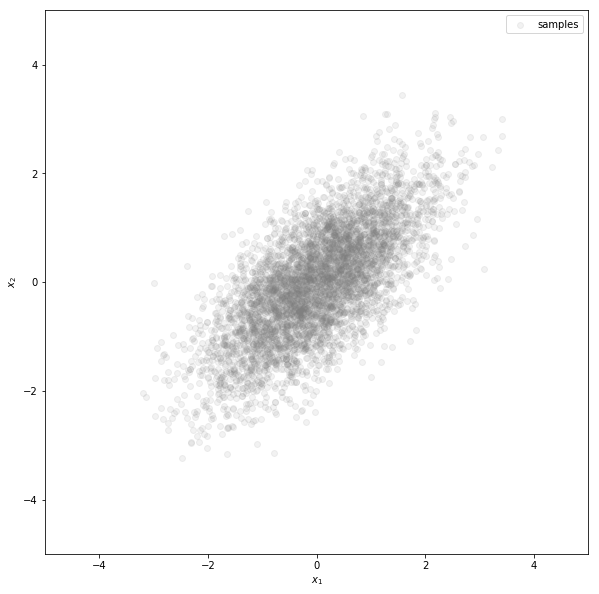

In [11]:
mv_fig

In [12]:
samples_y1 = samples[:,0]
samples_y2 = samples[:,1]

_, bins_y1 = np.histogram(samples_y1, 30)
_, bins_y2 = np.histogram(samples_y2, 30)

marg_fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.scatter(samples_y1, samples_y2, color=(0.5,0.5,0.5,0.1), label='samples')
plt.plot(bins_y1, 10 * get_pdf(bins_y1, mu1, sigma1) - 5, linewidth=2, color='r',label='marginal pdf')
plt.plot(10 * get_pdf(bins_y2, mu2, sigma2) - 5, bins_y2, linewidth=2, color='r')
plt.legend(loc=2)
plt.subplot(122)
plt.plot([np.ones(n_realisations), 2*np.ones(n_realisations)], [samples_y1, samples_y2], color=(0.5,0.5,0.5,0.1))
plt.ylim(-5, 5)
plt.xticks([1,2],['$x_1$', '$x_2$'])

([<matplotlib.axis.XTick at 0x16b2710d2b0>,
 <a list of 2 Text xticklabel objects>)

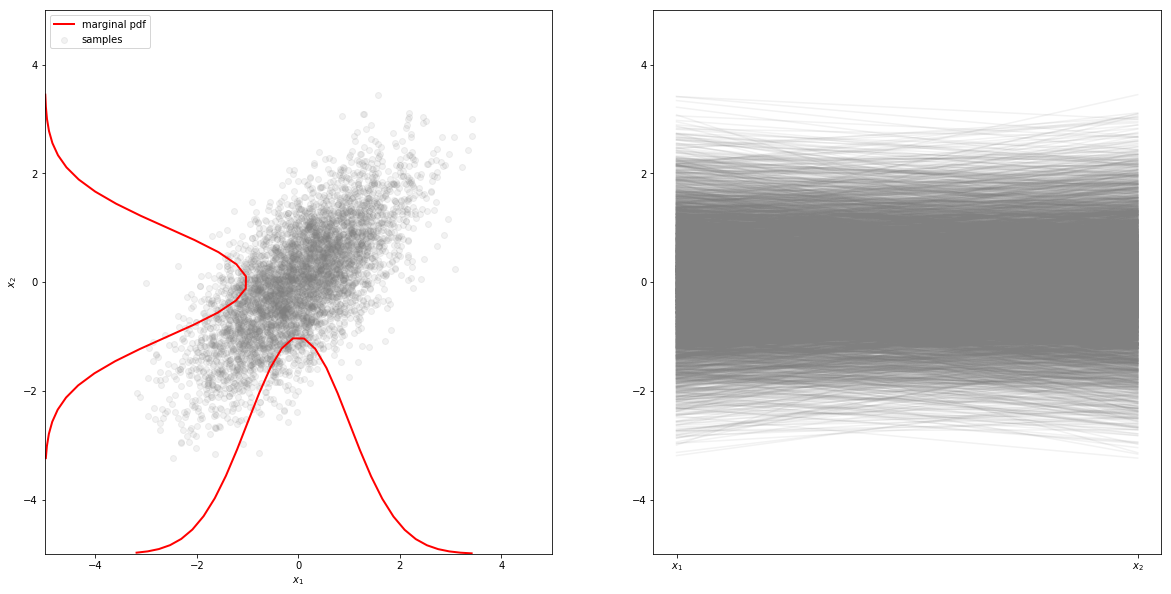

In [13]:
marg_fig

In [14]:
cond_fig = plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.scatter(samples[:,0], samples[:,1], color=(0.9,0.9,0.9,0.1))
plt.plot(bins_y1, 10 * get_pdf(bins_y1, mu1, sigma1) - 5, linewidth=2, color=(1,0,0,0.1))
plt.plot(10 * get_pdf(bins_y2, mu2, sigma2) - 5, bins_y2, linewidth=2, color=(1,0,0,0.1))

# get conditional mean and sigma (using bivariate derivation)
y2 = 1
mu1_2 = mu1 + (sigma1/sigma2) * rho * (y2 - mu2)
sigma1_2 = np.sqrt((1 - rho**2) * sigma1**2)

samples1_2 = np.random.normal(loc=mu1_2, scale=sigma1_2, size=n_realisations)
plt.scatter(samples1_2, np.ones(n_realisations)*y2, color=(0.5, 0.5, 0.5, 0.1), label='conditional samples')

_, bins_y1_2 = np.histogram(samples1_2, 30)
plt.plot(bins_y1_2, 10 * get_pdf(bins_y1_2, mu1_2, sigma1_2) - 5, linewidth=2, color='b', label='conditional pdf')
plt.legend(loc=2)


plt.subplot(122)
plt.plot([np.ones(n_realisations), 2*np.ones(n_realisations)], [samples1_2, np.ones(n_realisations)*y2], color=(0.5,0.5,0.5,0.1))
plt.ylim(-5, 5)
plt.xticks([1,2],['$x_1$', '$x_2$'])

([<matplotlib.axis.XTick at 0x16b2b8de828>,
 <a list of 2 Text xticklabel objects>)

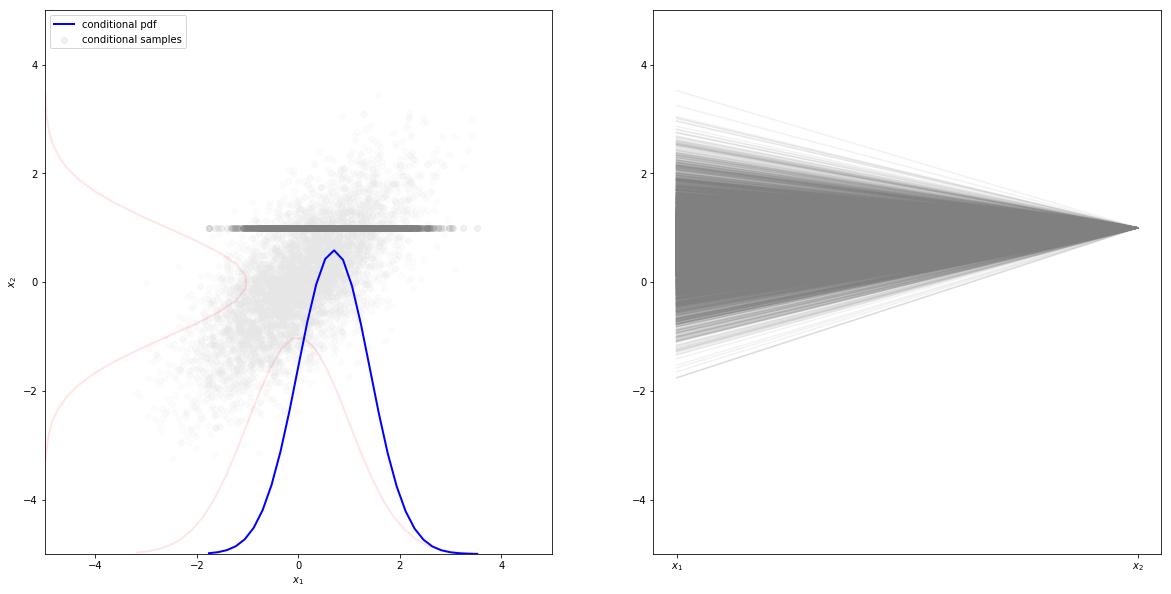

In [15]:
cond_fig

$\mathcal{GP}\left(\left[
\begin{matrix} \mu(x_1) \\ ... \\ \mu(x_n) \end{matrix}
\right],\left[
\begin{matrix} \Sigma(x_1,x_1) & ... & \Sigma(x_1,x_n) \\ ... & ... & ...\\ \Sigma(x_n,x_1) & ... & \Sigma(x_n,x_n) \end{matrix}
\right]\right)$

In [16]:
n = 100
x = np.linspace(0, 2*np.pi, n)  

# build mean function
mu = np.zeros(n) * x 

# build co-variance
D = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        D[i,j] = (x[i] - x[j]) ** 2
        D[j,i] = D[i,j]
sigma = np.exp(-D)

# make realisations
n_realisations = 10
Y = np.random.multivariate_normal(mu, sigma, n_realisations)

In [17]:
def plot_gp(n_realisations):
    Y = np.random.multivariate_normal(mu, sigma, size=n_realisations)
    gp_no_data = plt.figure(figsize=(15, 10))
    plt.ylabel('$y$')
    plt.xlabel('$x$')
    plt.xlim((0, 2*np.pi))
    plt.plot(x, Y.T, color=(0.2,0.2,0.2,0.2))
    return gp_no_data

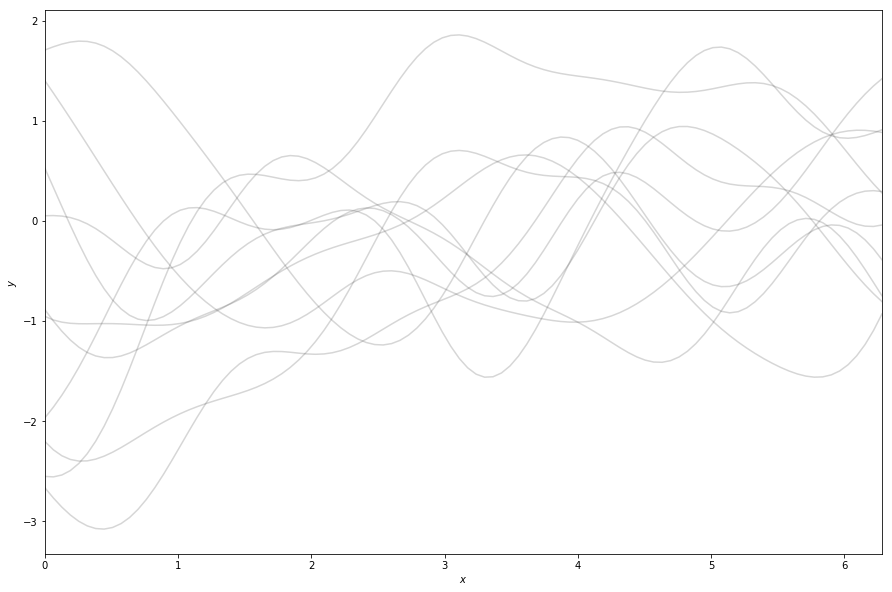

In [18]:
plot_gp(10)

In [19]:
def plot_cond_gp(n_obs):
    
    n = 100 # number of points to evaluate
    x = np.linspace(0, 2*np.pi, n)  

    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            D[i,j] = (x[i] - x[j]) ** 2
            D[j,i] = D[i,j]

    sigma = np.exp(-D)
    
    x_obs = np.random.uniform(size=n_obs) * 2*np.pi
    y_obs = np.sin(x_obs)

    D_obs = np.zeros((n_obs, n_obs))
    for i in range(n_obs):
        for j in range(i+1, n_obs):
            D_obs[i,j] = (x_obs[i] - x_obs[j]) ** 2
            D_obs[j,i] = D_obs[i,j]

    sigma_obs = np.exp(-D_obs)
    sigma_obsi = np.linalg.inv(sigma_obs)

    D_aug = np.zeros((n, n_obs))
    for i in range(n):
        for j in range(n_obs):
            D_aug[i,j] = (x[i] - x_obs[j]) ** 2

    sigma_aug = np.exp(-D_aug)
    
    mubar = np.linalg.multi_dot([sigma_aug, sigma_obsi, y_obs])
    sigmabar = sigma - np.linalg.multi_dot([sigma_aug, sigma_obsi, sigma_aug.T])

    Ybar = np.random.multivariate_normal(mubar, sigmabar, size=100)

    cond_gp = plt.figure(figsize=(15, 10))
    plt.ylabel('$y$')
    plt.xlabel('$x$')
    plt.scatter(x_obs, y_obs, color='blue')
    plt.plot(x, Ybar.T, color=(0.2,0.2,0.2,0.1))
    plt.xlim((0, 2*np.pi))
    return cond_gp

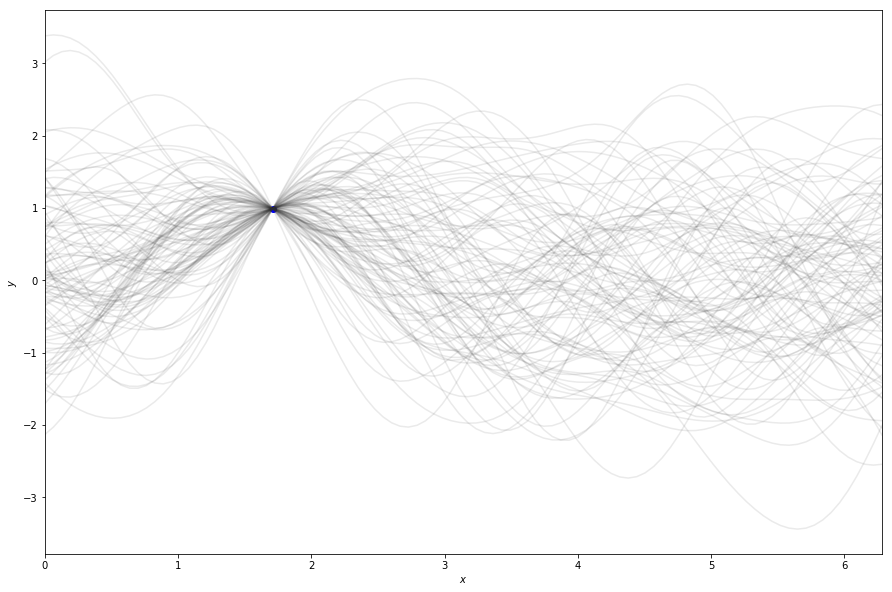

In [20]:
plot_cond_gp(1)

## Choosing where to generate data

In [21]:
def plot_cond_gp_ei(n_obs):
    
    n = 100 # number of points to evaluate
    x = np.linspace(0, 2*np.pi, n)  

    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            D[i,j] = (x[i] - x[j]) ** 2
            D[j,i] = D[i,j]

    sigma = np.exp(-D)
    
    x_obs = np.random.uniform(size=n_obs) * 2*np.pi
    y_obs = np.sin(x_obs)

    D_obs = np.zeros((n_obs, n_obs))
    for i in range(n_obs):
        for j in range(i+1, n_obs):
            D_obs[i,j] = (x_obs[i] - x_obs[j]) ** 2
            D_obs[j,i] = D_obs[i,j]

    sigma_obs = np.exp(-D_obs)
    sigma_obsi = np.linalg.inv(sigma_obs)

    D_aug = np.zeros((n, n_obs))
    for i in range(n):
        for j in range(n_obs):
            D_aug[i,j] = (x[i] - x_obs[j]) ** 2

    sigma_aug = np.exp(-D_aug)
    
    mubar = np.linalg.multi_dot([sigma_aug, sigma_obsi, y_obs])
    sigmabar = sigma - np.linalg.multi_dot([sigma_aug, sigma_obsi, sigma_aug.T])

    Ybar = np.random.multivariate_normal(mubar, sigmabar, size=100)

    cond_gp_ei = plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.ylabel('$y$')
    plt.xlabel('$x$')
    plt.scatter(x_obs, y_obs, color='blue')
    plt.plot(x, Ybar.T, color=(0.2,0.2,0.2,0.1))
    plt.xlim((0, 2*np.pi))
    
    plt.subplot(122)
    plt.xlabel('$x$')
    plt.ylabel('$P(y<y_{min})$')
    pi = sum(Ybar < min(y_obs)) / len(x)
    plt.plot(x, pi, color=(1.0, 0.56, 0.06))
    plt.xlim((0, 2*np.pi))
    return cond_gp_ei

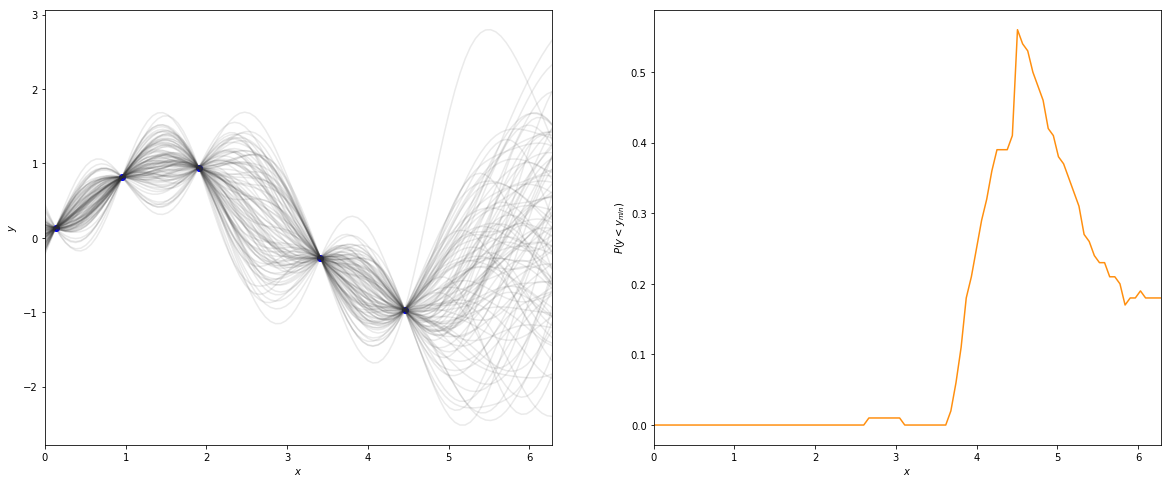

In [22]:
plot_cond_gp_ei(5)

### Other aquisition functions
`pure exploitation`

`pure exploration`

`constrained`

`multiobjective`

`noisy`

`stochastic`

## Using Bayesian optimisation to design a ducted fan

<img src="img/ductscene.png" style="width: 1000px; margin-left: auto; margin-right: auto;"/>

In [23]:
import scipy.special as sps

def class_shape_transform(parameters, te_thickness, bernstein_order, n_1, n_2, x_coordinates):
    shape_function = np.zeros((len(parameters), len(x_coordinates)))
    for iparam in range(len(parameters)):
        k = sps.comb(bernstein_order, iparam)
        shape_function[iparam,] = parameters[iparam] * k * (x_coordinates**iparam) * ((1 - x_coordinates)**(bernstein_order - iparam))
    
    z_coordinates = (x_coordinates**n_1) * ((1-x_coordinates)**n_2) * np.sum(shape_function,0) + x_coordinates*0.5*te_thickness;
    return z_coordinates 
    
def angle_of_attack_transform(coordinates, aoa):
    aoa_rad = np.deg2rad(aoa)
    rotation_matrix = np.array([[np.cos(aoa_rad), -np.sin(aoa_rad)],[np.sin(aoa_rad), np.cos(aoa_rad)]])
    return np.dot(coordinates.T, rotation_matrix)
    
def point_of_inflection(parameters, te_thickness, bernstein_order, n_1, n_2, x_coordinates, aoa):
    z_coordinates = -class_shape_transform(parameters, te_thickness, bernstein_order, n_1, n_2, x_coordinates)
    coordinates = np.array([x_coordinates, z_coordinates]) 
    coordinates_transform = angle_of_attack_transform(coordinates, aoa)   
    dzdx = np.diff(coordinates_transform[:,1])
    for ipoint in range(len(dzdx)):
        if dzdx[ipoint] > 0 or dzdx[ipoint] == max(dzdx):
            break
    return np.reshape(coordinates_transform[ipoint,:],2)

In [24]:
bernstein_order_upper = 1
bernstein_order_lower = 3
n_1 = 0.5
n_2 = 1
x_coordinates = np.arange(0, 1.01, 0.01)
te_thickness = 0.02
blade_radius = 101.6 #mm
tip_gap_ratio = 0.02
tip_gap_at_fan_location = tip_gap_ratio * blade_radius
rotate_rad = np.deg2rad(-90)
rotation_matrix = np.array([[np.cos(rotate_rad), -np.sin(rotate_rad)],[np.sin(rotate_rad), np.cos(rotate_rad)]]).T

bu1 = widgets.FloatSlider(value=0.15, min=0.1, max=0.2, step=0.001, description='upper leading edge')
bu2 = widgets.FloatSlider(value=0.2, min=0.1, max=0.3, step=0.001, description='upper botail')
bl1 = widgets.FloatSlider(value=0.4, min=0.3, max=0.5, step=0.001, description='lower leading edge')
bl2 = widgets.FloatSlider(value=0.1, min=0.05, max=0.25, step=0.001, description='lower forebody')
bl3 = widgets.FloatSlider(value=0.2, min=0.1, max=0.3, step=0.001, description='lower aftbody')
bl4 = widgets.FloatSlider(value=0.15, min=0.05, max=0.25, step=0.001, description='lower botail')
aoa = widgets.FloatSlider(value=4, min=0, max=6, step=0.1, description='angle of attack')          
btoc = widgets.FloatSlider(value=2, min=1, max=4, step=0.1, description='blade to chord ratio')              

plt.close()
plt.cla()
plt.clf()
du_ax = plt.gca()


def plot_duct(bu1, bu2, bl1, bl2, bl3, bl4, aoa, btoc):
    parameters_upper = np.array([bu1, bu2])
    parameters_lower = np.array([bl1, bl2, bl3, bl4])
    z_coordinates_upper = class_shape_transform(parameters_upper, te_thickness, bernstein_order_upper, n_1, n_2, x_coordinates)
    z_coordinates_lower = -class_shape_transform(parameters_lower, te_thickness, bernstein_order_lower, n_1, n_2, x_coordinates)
    upper_coordinates = angle_of_attack_transform(np.array([x_coordinates, z_coordinates_upper]), aoa)
    lower_coordinates = angle_of_attack_transform(np.array([x_coordinates, z_coordinates_lower]), aoa)
    fan_location = point_of_inflection(parameters_lower, te_thickness, bernstein_order_lower, n_1, n_2, np.arange(0, 1.01, 0.01), aoa) 
    chord = blade_radius / btoc
    le_radius = blade_radius + abs(fan_location[1]*chord) + tip_gap_at_fan_location
    x_fan = fan_location[0] * chord
    z_fan = le_radius
    du_ax.clear()
    du_ax.axis('equal')
    du_ax.axis('off')
    du_ax.plot([-blade_radius, blade_radius], [0, 0], color='k')
    upper_surface1_rot = np.dot(np.vstack([upper_coordinates[:,0]*chord - x_fan, upper_coordinates[:,1]*chord + z_fan]).T, rotation_matrix)
    du_ax.plot(upper_surface1_rot[:,0], upper_surface1_rot[:,1], color='grey')
    lower_surface1_rot = np.dot(np.vstack([lower_coordinates[:,0]*chord - x_fan, lower_coordinates[:,1]*chord + z_fan]).T, rotation_matrix)
    du_ax.plot(lower_surface1_rot[:,0], lower_surface1_rot[:,1], color='grey')
    du_ax.fill_betweenx(upper_surface1_rot[:,1], upper_surface1_rot[:,0], lower_surface1_rot[:,0], color='grey', alpha='0.5')
    upper_surface2_rot = np.dot(np.vstack([upper_coordinates[:,0]*chord - x_fan, -upper_coordinates[:,1]*chord - 2*le_radius + z_fan]).T, rotation_matrix)
    du_ax.plot(upper_surface2_rot[:,0], upper_surface2_rot[:,1], color='grey')
    lower_surface2_rot = np.dot(np.vstack([lower_coordinates[:,0]*chord - x_fan, -lower_coordinates[:,1]*chord - 2*le_radius + z_fan]).T, rotation_matrix)
    du_ax.plot(lower_surface2_rot[:,0], lower_surface2_rot[:,1], color='grey')
    du_ax.fill_betweenx(upper_surface2_rot[:,1], upper_surface2_rot[:,0], lower_surface2_rot[:,0], color='grey', alpha='0.5')
    display(du_ax.figure)

duct_out = widgets.interactive_output(plot_duct, {'bu1':bu1, 'bu2':bu2, 'bl1':bl1, 'bl2':bl2, 'bl3':bl3, 'bl4':bl4, 'aoa':aoa, 'btoc':btoc})
duct_box = widgets.HBox([widgets.VBox([bu1, bu2, bl1, bl2, bl3, bl4, aoa, btoc]), duct_out])

In [25]:
display(duct_box)

<img src="img/fan_overview.png" style="width: 100%; margin-left: auto; margin-right: auto;"/>

<img src="img/animated.gif" style="height: 1000px; margin-left: auto; margin-right: auto;"/>

## Using Bayesian optimisation to design skateboard shoes!

<img src="img/final_shoe.jpg" style="width: 1200px; margin-left: auto; margin-right: auto;"/>

<img src="img/shoe_profile.png" style="width:1000px; margin-left: auto; margin-right: auto;"/>

<video controls src="img/grip.mp4" style="width: 100%; margin-left: auto; margin-right: auto;"/>

<img src="img/shoe_overview.png" style="width: 100%; margin-left: auto; margin-right: auto;"/>

<img src="img/grip2.gif" style="height: 800px; margin-left: auto; margin-right: auto;"/>

<img src="img/sole.gif" style="width: 100%; margin-left: auto; margin-right: auto;"/>

<video controls src="img/sole.mp4" style="width: 100%; margin-left: auto; margin-right: auto;"/>

## Using Bayesian optimisation in aesthetics

`not all products need to be engineered...`

`those that aren't are desirable because they look or feel good`

`what looks or feels good is subjective...`

`so we need to learn some underlying utility to make improvements`

In [26]:
class PreferenceBasedGP(object):
    def __init__(self, r, c, z, theta):
        self.r = r
        self.c = c
        self.z = z
        self.theta = theta
        self.preferences, self.X = self._get_preferences()
        self.L = self._get_L()
        self.Y = None
        self.Y_guess = None
    
    def _get_preferences(self):
        x2ind = {}
        ind = 0
        prefinds = []
        for i in range(len(self.z)):
            if self.r[i] not in x2ind:
                x2ind[self.r[i]] = ind
                ind += 1
            if self.c[i] not in x2ind:
                x2ind[self.c[i]] = ind
                ind += 1
            prefinds.append((x2ind[self.r[i]], x2ind[self.c[i]], self.z[i]))
        X = np.array([[x] for x, _ in sorted(x2ind.items(), key=lambda x:x[1])])
        return prefinds, X
    
    def get_covar(self, x, theta):
        n, m = x.shape
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                D = (1/theta[0:m]) * (x[i] - x[j]) ** 2
                K[i,j] = np.exp(-sum(D))
                K[j,i] = K[i,j]
        return K + theta[m]*np.eye(n) + np.eye(n)
    
    def _get_L(self):
        K = self.get_covar(self.X, self.theta)
        L = np.linalg.cholesky(K)
        return L
    
    def _get_initial_guess(self):
        vs = set(self.r)
        lastY = {}
        ymin = -0.5
        ymax = 0.5
        
        if self.Y is None:
            start = []
            for x in self.X.tolist():
                if tuple(x) in lastY:
                    start.append(lastY[tuple(x)])
                else:
                    if tuple(x) in vs:
                        start.append(ymax)
                    else:
                        start.append(ymin)
        else:
            for x, y in zip(self.X.tolist(), self.Y):
                lastY[tuple(x)] = y
            start = []
            for x in self.X.tolist():
                if tuple(x) in lastY:
                    start.append(lastY[tuple(x)])
                else:
                    if tuple(x) in vs:
                        start.append(ymax)
                    else:
                        start.append(ymin)
        return start
    
    def CDF(self, x):
        return 0.5 * (1 + self.erf((x) * 0.707106))
            
    def PDF(self, x):
        return  np.exp(-(x**2/2)) * 0.398942
    
    def erf(self, z):
        t = 1.0 / (1.0 + 0.5 * np.abs(z))
        # use Horner's method
        ans = 1 - t * np.exp( -z*z -  1.26551223 +
                                    t * ( 1.00002368 +
                                    t * ( 0.37409196 + 
                                    t * ( 0.09678418 + 
                                    t * (-0.18628806 + 
                                    t * ( 0.27886807 + 
                                    t * (-1.13520398 + 
                                    t * ( 1.48851587 + 
                                    t * (-0.82215223 + 
                                    t * ( 0.17087277))))))))))
        
        if isinstance(ans, np.float64): 
            if z < 0.0:
                ans = -ans
        else:
            ans[z<0.0] = -ans[z<0.0]            
        return ans
            
    
    def S(self, x):
        logCDFs = 0.
        sigma = 1
        epsilon = 1e-10
        Z = np.sqrt(2) * sigma
        for v, u, d in self.preferences:
            logCDFs += (d+1) * np.log(self.CDF((x[v]-x[u])/Z)+epsilon)
            Lx = np.linalg.solve(self.L, x)
            val = -logCDFs + np.dot(Lx, Lx)/2
        return val
        
    def train(self):
        y_guess = self._get_initial_guess()
        result = so.minimize(self.S, y_guess)
        self.Y = result.x
        
    def predict(self, xpred):
        n, m = self.X.shape
        if self.theta is None:
            raise 'Need to train before predict'
        K = self.get_covar(self.X, self.theta)
        K_xpred = self.get_covar(xpred, self.theta)

        npred = len(xpred)
        K_aug = np.zeros((npred, n))
        for i in range(npred):
            for j in range(n):
                D = (1/self.theta[0:m]) * (xpred[i] - self.X[j]) ** 2
                K_aug[i,j] = np.exp(-sum(D))
        
        # using chol
        L = np.linalg.cholesky(K)
        Lr = np.linalg.solve(L, K_aug.T)
        mubar = np.dot(Lr.T, np.linalg.solve(L, self.Y))
        s2bar = np.clip(K_xpred - np.dot(Lr.T, np.linalg.solve(L, K_aug.T)), 1e-10, np.inf)
        sbar = np.sqrt(np.abs(np.diag(s2bar)))
        return mubar.flatten(), sbar.flatten()
    
    def ei(self, xpred):
        ypred, spred = self.predict(xpred)
        ymax = max(self.Y)
        ydiff = ypred - ymax
        Z = ydiff / spred
        exp_imp = (ydiff * self.CDF(Z)) + (spred * self.PDF(Z))
        return exp_imp
    
    def negei(self, xpred):
        exp_imp = self.ei(np.array([xpred]))
        return -exp_imp
    
    def add_data(self, r, c, z):
        for i in r: self.r.append(i)
        for j in c: self.c.append(j)
        for k in z: self.z.append(k)
        self.preferences, self.X = self._get_preferences()
        self.L = self._get_L()
        self.train()    

In [27]:
from PIL import Image

def change_contrast(x):
    img = Image.open("img/warhol.jpeg")
    img.load()
    level = (1000 * x) - 500
    factor = (259 * (level+255)) / (255 * (259-level))
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            color = img.getpixel((x, y))
            new_color = tuple(int(factor * (c-128) + 128) for c in color)
            img.putpixel((x, y), new_color)
    return img

In [28]:
plt.close()
np.random.seed(30786)
n = 5
xn = lhs(1,n)
left_value = np.random.random()
right_value = xn[0][0]

pref_out_left=widgets.Output()
pref_out_right=widgets.Output()

pref_button_left=widgets.Button(description='Left is best')
pref_button_right=widgets.Button(description='Right is best')

pref_box=widgets.HBox(children=(widgets.VBox(children=(pref_out_left, pref_button_left)),
                            widgets.VBox(children=(pref_out_right, pref_button_right))))

class PrefClicks:
    def __init__(self, left_value, right_value, xn):
        self.i = 0
        self.left_value = left_value
        self.right_value = right_value
        self.xn = xn
        self.n = len(xn)
        self.r = []
        self.c = []
        self.z = []
        #self.gp = None
    
    def click_left(self, b):
        if b is not None:
            self.i += 1
            self.r.append(self.left_value)
            self.c.append(self.right_value)
            self.z.append(1)
        if self.i == self.n:
            self.gp = PreferenceBasedGP(r=self.r, c=self.c, z=self.z, theta=np.array([0.05, 0.005]))
            self.gp.train()
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.right_value = xmin[0]
        elif self.i > self.n:
            self.gp.add_data(r=[self.left_value], c=[self.right_value], z = [1])
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.right_value = xmin[0]
        else:
            if self.i > 0:
                self.right_value = self.xn[self.i][0]
        img_right = change_contrast(self.right_value)
        ax_right.imshow(np.asarray(img_right))
        with pref_out_right:
            clear_output(wait=True)
            display(ax_right.figure)

    def click_right(self, b):
        if b is not None:
            self.i += 1
            self.r.append(self.left_value)
            self.c.append(self.right_value)
            self.z.append(0)
        if self.i == self.n:
            self.gp = PreferenceBasedGP(r=self.r, c=self.c, z=self.z, theta=np.array([0.05, 0.005]))
            self.gp.train()
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.left_value = xmin[0]
        elif self.i > self.n:
            self.gp.add_data(r=[self.left_value], c=[self.right_value], z = [0])
            xmin, ymin = multistart_minimize(self.gp.negei, bounds=[(0, 1)])
            self.left_value = xmin[0]
        else:
            if self.i > 0:
                self.left_value = self.xn[self.i][0]
        img_left = change_contrast(self.left_value)
        ax_left.imshow(np.asarray(img_left))
        with pref_out_left:
            clear_output(wait=True)
            display(ax_left.figure)

plt.cla()
plt.ioff()
ax_left = plt.gca()
ax_left.axis('off')

plt.ioff()
ax_right = plt.gca()
ax_right.axis('off')

pref_clicks = PrefClicks(left_value, right_value, xn)
pref_button_left.on_click(pref_clicks.click_left)
pref_button_right.on_click(pref_clicks.click_right)

In [29]:
display(pref_box)
pref_clicks.click_left(None)
pref_clicks.click_right(None)

In [30]:
def gp_pref():
    ni = 50
    xi = np.linspace(0, 1, ni).reshape(ni,1)

    gp_pref = plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.scatter(pref_clicks.gp.X, pref_clicks.gp.Y, label='Observations')
    ypred, spred = pref_clicks.gp.predict(xi)
    ei = pref_clicks.gp.ei(xi)
    plt.plot(xi, ypred, color=(0.122, 0.529, 0.8), label='GP utility prediction')
    plt.fill_between(xi.flatten(), ypred+2*spred, ypred-2*spred, color=(0.122, 0.529, 0.8, 0.2))
    plt.xlabel('Design parameter value $x_1$')
    plt.ylabel('Objective value $f(x_1)$')  

    plt.subplot(122)
    plt.plot(xi, ei, color=(1.0, 0.56, 0.06))
    plt.xlabel('Design parameter value $x_1$')
    plt.ylabel('Expected improvement $EI(f(x_1) > y_{max})$')
    return gp_pref

In [31]:
# uncomment and run to see the latent utility objective
#gp_pref()

<img src="img/smoke.gif" style="height:600px; margin-left: auto; margin-right: auto;"/>

In [32]:
import subprocess
def get_plume(x):
    source_velocity = 4*x[0]
    normal_velocity = 6*x[1] - 2
    file_name = 'sample_test' 
    # run simulation
    p = subprocess.Popen('blender --python run_blender.py -- {} {} {}'.format(source_velocity, normal_velocity, file_name))

In [33]:
# if you have blender installed try this...
#get_plume([0.9195404,  0.03777169])

<img src="img/smoke_overview.png" style="width: 100%; margin-left: auto; margin-right: auto;"/>

<img src="img/smoke_step.gif" style="width:100%; margin-left: auto; margin-right: auto;"/>

`thanks for listening`